<a href="https://colab.research.google.com/github/saloniprojects4800/InternProject4/blob/main/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import xgboost as xgb


Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Project4/decisionforge_enterprise_dataset.csv"
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'])
df.head()


,date,demand_forecast,actual_demand,inventory_level,supplier_delay_days,transport_cost_index,sales_growth_pct,machine_downtime_hours,anomaly_flag,supply_chain_risk
0,2022-01-01,560.0,589.0,628.0,2,0.99,0.36,5.10,0,1
1,2022-01-02,483.0,403.0,942.0,2,1.28,7.10,0.07,0,0
2,2022-01-03,578.0,365.0,1076.0,3,1.04,0.03,3.88,0,0
3,2022-01-04,683.0,480.0,1766.0,2,0.87,11.18,0.52,0,0
4,2022-01-05,472.0,456.0,1367.0,4,1.03,5.35,3.78,0,1


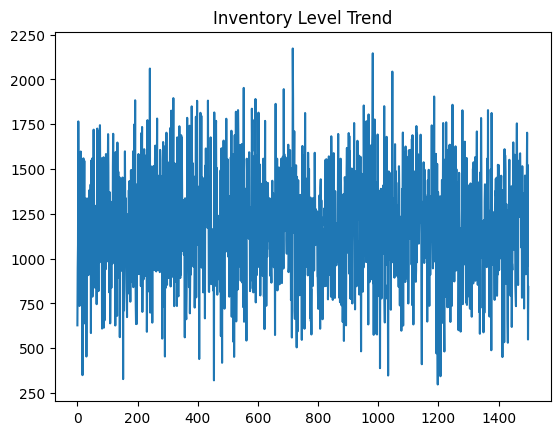

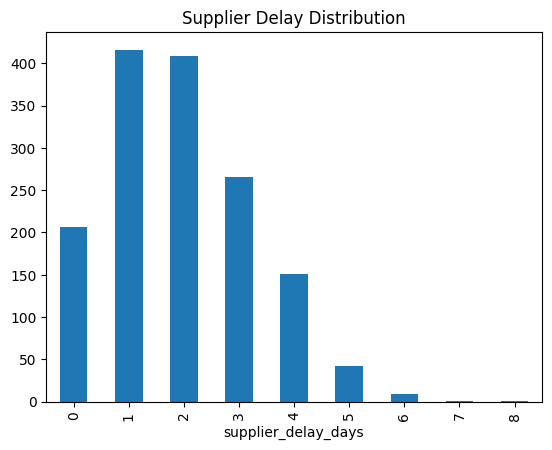

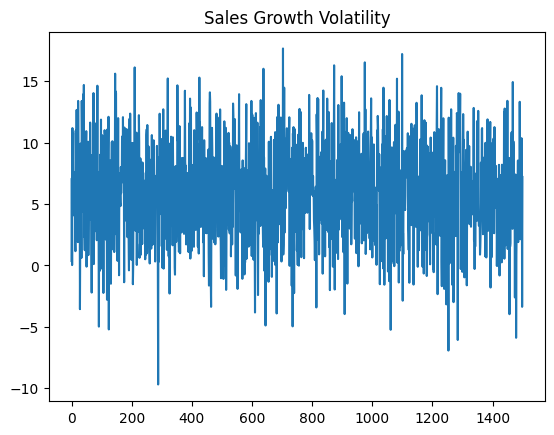

In [ ]:
plt.figure()
df['inventory_level'].plot()
plt.title("Inventory Level Trend")
plt.show()

plt.figure()
df['supplier_delay_days'].value_counts().sort_index().plot(kind='bar')
plt.title("Supplier Delay Distribution")
plt.show()

plt.figure()
df['sales_growth_pct'].plot()
plt.title("Sales Growth Volatility")
plt.show()


In [ ]:
features = [
    'demand_forecast','actual_demand','inventory_level',
    'supplier_delay_days','transport_cost_index',
    'sales_growth_pct','machine_downtime_hours','anomaly_flag'
]

X = df[features]
y = df['supply_chain_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    df[features], y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)


In [ ]:
def logistic_model(Xtr, ytr, Xte):
    model = LogisticRegression()
    model.fit(Xtr, ytr)
    return model.predict_proba(Xte)[:,1]

def random_forest_model(Xtr, ytr, Xte):
    model = RandomForestClassifier(n_estimators=200)
    model.fit(Xtr, ytr)
    return model.predict_proba(Xte)[:,1]

def xgboost_model(Xtr, ytr, Xte):
    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(Xtr, ytr)
    return model.predict_proba(Xte)[:,1]

def isolation_forest_score(X):
    model = IsolationForest(contamination=0.08)
    return -model.fit_predict(X)

def kmeans_cluster(X):
    model = KMeans(n_clusters=3)
    return model.fit_predict(X)


In [ ]:
lr_score = logistic_model(X_train, y_train, X_test)
rf_score = random_forest_model(X_train, y_train, X_test)
xgb_score = xgboost_model(X_train, y_train, X_test)

anomaly_score = isolation_forest_score(X_test)
cluster_label = kmeans_cluster(X_test)


In [ ]:
def decision_engine(lr, rf, xgb, anomaly):
    risk_score = (0.3*lr + 0.4*rf + 0.3*xgb)
    confidence = 1 - np.std([lr, rf, xgb], axis=0)
    final_decision = ((risk_score > 0.6) | (anomaly == 1)).astype(int)
    return risk_score, confidence, final_decision


In [ ]:
def opportunity_engine(df):
    opp = (
        0.5 * df['sales_growth_pct'] +
        0.3 * (df['demand_forecast'] - df['actual_demand']) +
        0.2 * (1 / (1 + df['supplier_delay_days']))
    )
    return (opp - opp.min()) / (opp.max() - opp.min())


In [ ]:
opportunity_score = opportunity_engine(X_test_df)


In [ ]:
def rule_override(df, decision):
    override = decision.copy()
    override[
        (df['supplier_delay_days'] > 6) |
        (df['inventory_level'] < 400)
    ] = 1
    return override


In [ ]:
final_decision = rule_override(X_test_df, decision)


In [ ]:
def risk_appetite_adjustment(risk, opportunity, appetite="medium"):
    if appetite == "low":
        return risk * 1.2 - opportunity * 0.3
    if appetite == "high":
        return risk * 0.8 - opportunity * 0.6
    return risk - opportunity * 0.4

adjusted_score = risk_appetite_adjustment(
    risk_score,
    opportunity_score.values,
    appetite="medium"
)


In [ ]:
decision_card = pd.DataFrame({
    "RiskScore": risk_score,
    "OpportunityScore": opportunity_score.values,
    "Confidence": confidence,
    "AdjustedScore": adjusted_score,
    "FinalDecision": final_decision
})

decision_card.head()


,RiskScore,OpportunityScore,Confidence,AdjustedScore,FinalDecision
0,0.806650,0.820571,0.761191,0.478421,1
1,0.011570,0.347818,0.989869,-0.127558,0
2,0.065978,0.581344,0.911609,-0.166560,0
3,0.008983,0.537808,0.993908,-0.206140,0
4,0.124232,0.407786,0.831807,-0.038883,0


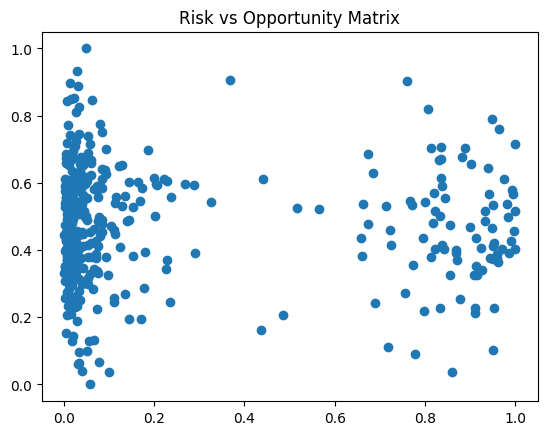

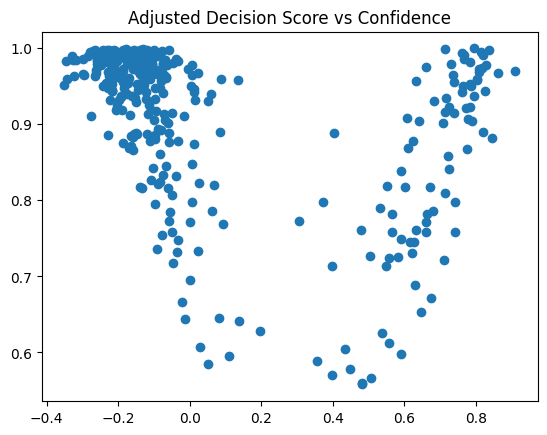

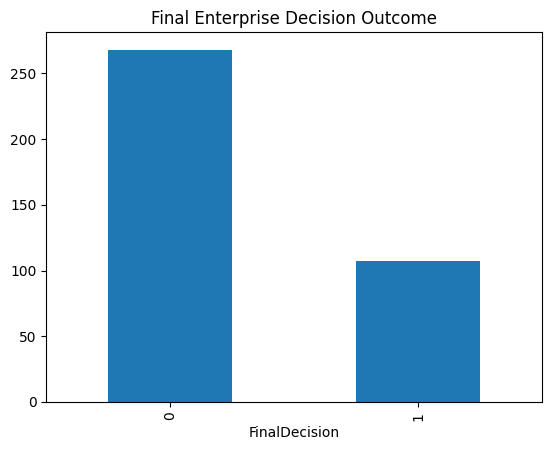

In [ ]:
plt.figure()
plt.scatter(decision_card['RiskScore'], decision_card['OpportunityScore'])
plt.title("Risk vs Opportunity Matrix")
plt.show()

plt.figure()
plt.scatter(decision_card['AdjustedScore'], decision_card['Confidence'])
plt.title("Adjusted Decision Score vs Confidence")
plt.show()

plt.figure()
decision_card['FinalDecision'].value_counts().plot(kind='bar')
plt.title("Final Enterprise Decision Outcome")
plt.show()


In [ ]:
stress_df = decision_card.copy()
stress_df['RiskScore'] = stress_df['RiskScore'] * 1.3
stress_df['StressDecision'] = (stress_df['RiskScore'] > 0.6).astype(int)


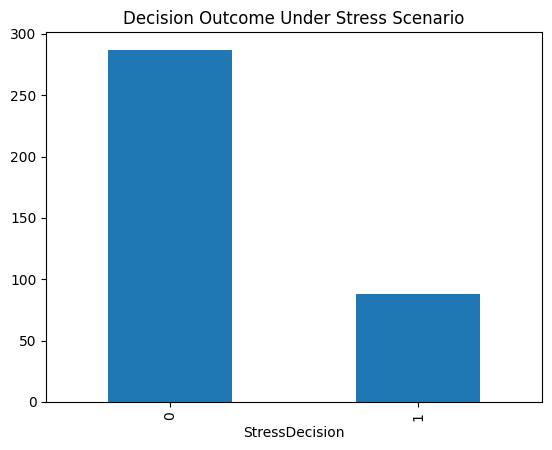

In [ ]:
plt.figure()
stress_df['StressDecision'].value_counts().plot(kind='bar')
plt.title("Decision Outcome Under Stress Scenario")
plt.show()


In [ ]:
print("DECISIONFORGE™ EXECUTIVE SUMMARY")
print(decision_card.describe())


DECISIONFORGE™ EXECUTIVE SUMMARY
        RiskScore  OpportunityScore  Confidence  AdjustedScore  FinalDecision
count  375.000000        375.000000  375.000000     375.000000     375.000000
mean     0.242503          0.469828    0.913045       0.054572       0.285333
std      0.348993          0.173727    0.104569       0.356945       0.452176
min      0.000877          0.000000    0.557794      -0.350726       0.000000
25%      0.016899          0.370087    0.882889      -0.173196       0.000000
50%      0.049274          0.455332    0.959400      -0.108791       0.000000
75%      0.277944          0.590450    0.985838       0.090634       1.000000
max      0.999674          1.000000    0.999704       0.909633       1.000000
